<a href="https://colab.research.google.com/github/aleksandrgritckevich/DLS-Final-Project/blob/main/Project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Исследовательский Трек**


## Выбор Фреймворка

В проекте я буду использовать фреймворк torchvision.models.detection. А именно буду сравнивать модели SSD и Faster-RCNN из него.



## Запуск детектора на случайных изображениях

Для начала попробуем запустить эти 2 модели на паре случайных изображений из интернета и убедиться, что они выдают какой-то результат.

In [1]:
%%capture
!pip install torchvision==0.15.2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from bs4 import BeautifulSoup
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as tt
from torchvision import datapoints
from torchvision.transforms.v2 import functional as F
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights,ssd300_vgg16,SSD300_VGG16_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.models.detection.ssd import SSDHead
from torch.optim.lr_scheduler import StepLR
from torchvision.ops import box_iou

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [16]:
!gdown 1--OASZ0ecw8CTZOwT2UqUZ7e6xKbDKnx
!gdown 1NC2Y0E_puyjZEylOlL1reGyVxtcCs7el
!gdown 11xcBkUadqlFoW5_3A5Umw6XwRgyIDgTG
!gdown 1yzor6zHfd-r_81qylIjgINK_UKms93GF
!gdown 1eMcQ4uxS11h7Z6_wwNXKfurF5q_Fz_hR

Downloading...
From: https://drive.google.com/uc?id=1--OASZ0ecw8CTZOwT2UqUZ7e6xKbDKnx
To: /content/faster-rcnn
100% 175M/175M [00:00<00:00, 209MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NC2Y0E_puyjZEylOlL1reGyVxtcCs7el
To: /content/ssd
100% 97.7M/97.7M [00:00<00:00, 193MB/s]
Downloading...
From: https://drive.google.com/uc?id=11xcBkUadqlFoW5_3A5Umw6XwRgyIDgTG
To: /content/person_at_the_table.jpg
100% 141k/141k [00:00<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yzor6zHfd-r_81qylIjgINK_UKms93GF
To: /content/cats.jpg
100% 65.0k/65.0k [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eMcQ4uxS11h7Z6_wwNXKfurF5q_Fz_hR
To: /content/cards.zip
100% 38.3M/38.3M [00:00<00:00, 95.1MB/s]


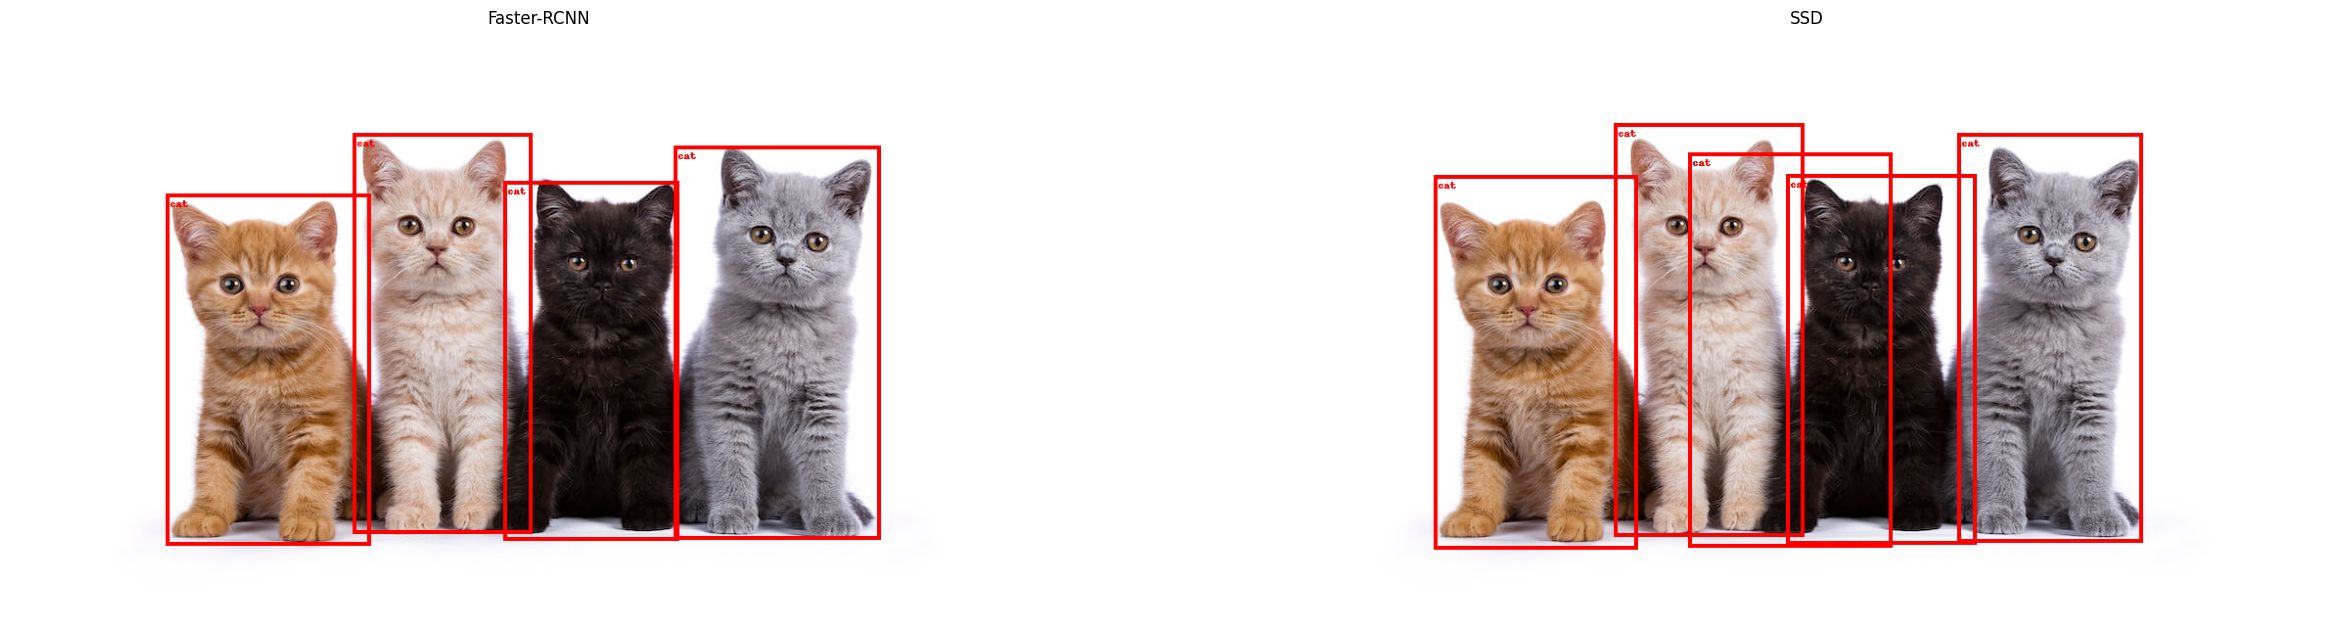

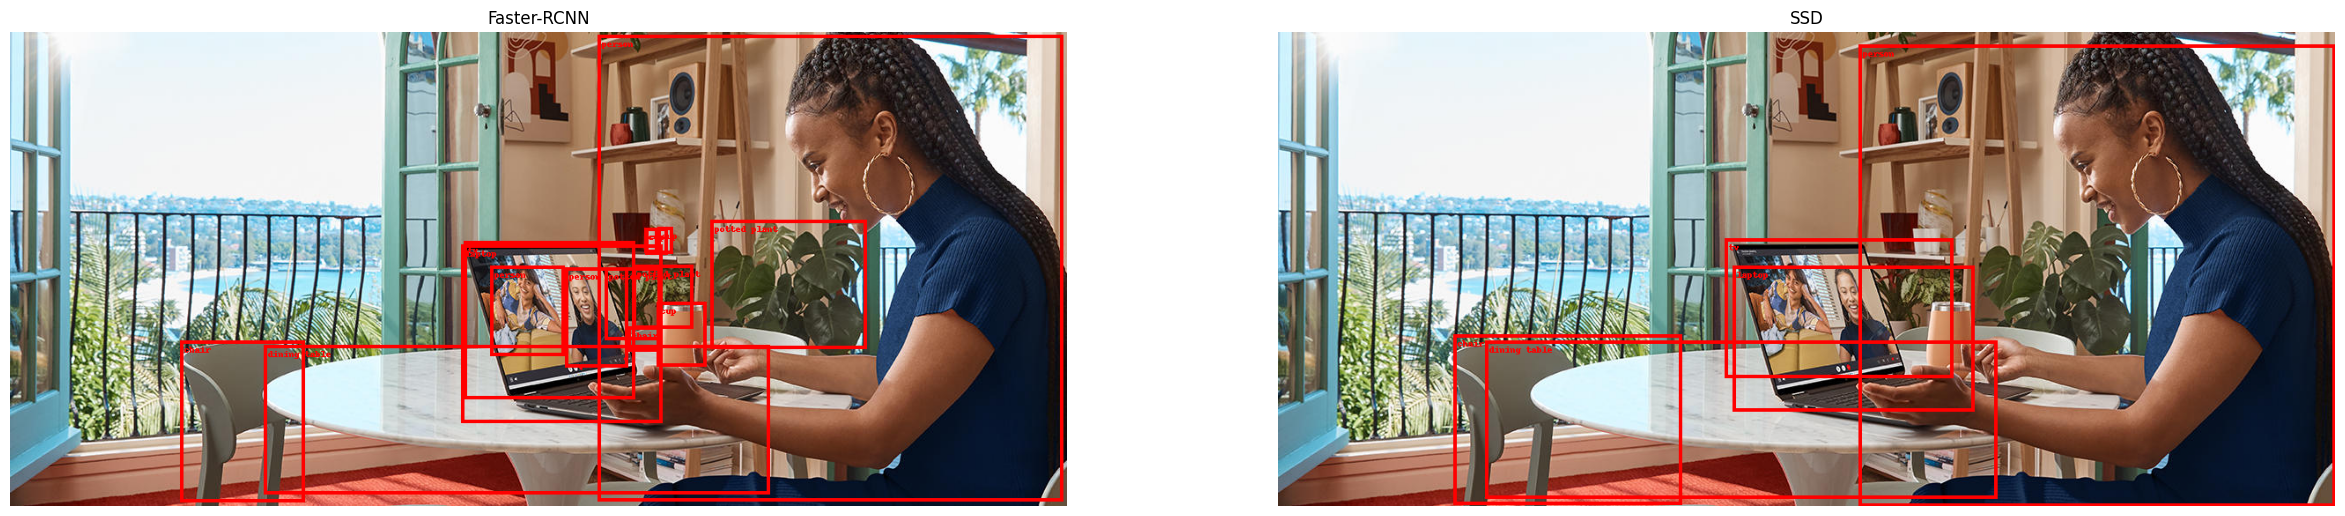

In [17]:
# Загружаем изображения
img1 = read_image("./cats.jpg").to(device)
img2 = read_image("./person_at_the_table.jpg").to(device)


# Инициализируем модели
weights_frcnn = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model_frcnn = fasterrcnn_resnet50_fpn_v2(weights=weights_frcnn, box_score_thresh=0.5).to(device)
model_frcnn.eval()

weights_ssd = SSD300_VGG16_Weights.DEFAULT
model_ssd = ssd300_vgg16(weights=weights_ssd, box_score_thresh=0.8).to(device)
model_ssd.eval()

# Инициализируем трансформации необходимын для инференса
preprocess_frcnn = weights_frcnn.transforms()
preprocess_ssd = weights_ssd.transforms()

for img in [img1,img2]:
  # Применяем трансформации к изображениям
  batch_frcnn = [preprocess_frcnn(img)]
  batch_ssd = [preprocess_ssd(img)]

  # Находим предсказания моделей
  prediction_frcnn = model_frcnn(batch_frcnn)[0]
  prediction_ssd = model_ssd(batch_ssd)[0]

  # Для SSD отфильтруем предсказания с малым скором
  prediction_ssd_filtered = {}
  indices = [i for i in range(len(prediction_ssd['scores'])) if prediction_ssd['scores'][i]>0.3]
  prediction_ssd_filtered["boxes"] = prediction_ssd['boxes'][indices]
  prediction_ssd_filtered["scores"] = prediction_ssd['scores'][indices]
  prediction_ssd_filtered["labels"] = prediction_ssd['labels'][indices]

  labels_frcnn = [weights_frcnn.meta["categories"][i] for i in prediction_frcnn["labels"]]
  labels_ssd = [weights_ssd.meta["categories"][i] for i in prediction_ssd_filtered["labels"]]

  # Нарисуем картинки с баундин боксами
  box = draw_bounding_boxes(img, boxes=prediction_frcnn["boxes"],
                            labels=labels_frcnn,
                            colors="red",
                            width=4, font_size=30)
  im1 = to_pil_image(box.detach())

  box = draw_bounding_boxes(img, boxes=prediction_ssd_filtered["boxes"],
                              labels=labels_ssd,
                              colors="red",
                              width=4, font_size=30)
  im2 = to_pil_image(box.detach())

  plt.figure(figsize=(30, 8))
  plt.subplot(1,2,1)
  plt.imshow(np.asarray(im1))
  plt.axis('off')
  plt.title("Faster-RCNN")

  plt.subplot(1,2,2)
  plt.imshow(np.asarray(im2))
  plt.axis('off')
  plt.title("SSD")

Как можно увидеть, модели дают предсказания на двух рандомных картинках, определяют людей, растения, котиков и т.д. Т.е. инференс работает.

## Выбор Датасета

Я буду работать с датасетом, состоящим из изображений различных игральных карт. Наша задача научиться верно детектировать карты различных типов (девятки, десятки, вольты, дамы, короли и тузы) в разных положениях, при разных условиях освещения.

В этом пункте я просто распаковываю архив с изображениями и разметкой.

In [5]:
%%capture
!unzip "cards.zip"

## Предобработка Данных

В этом пункте я пишу свой датасет для картинок игральных карт, в котором происходит обработка изображений и их разметки, так что они полностью готовы для загрузки в даталоадер и последующего обучения моделей.

In [18]:
## Пути к трейн и тест данным
train_path = "/content/cards/train"
test_path = "/content/cards/test"

## Словари с соответствующими названиями классов и их номерами. Добавил фейк класс под номером 0,
## потому, что модели почему-то отказывались предсказывать нулевой класс, а с фейковым классом все работает.
label_to_index = {"fake":0,"nine":1,"ten":2,"jack":3,"queen":4,"king":5,"ace":6}
index_to_label = {0:"fake",1:"nine",2:"ten",3:"jack",4:"queen",5:"king",6:"ace"}


class CardsDataset(Dataset):
  def __init__(self,path,transforms):
    ## Создаем списки с путями к изоюражениям и соответствующим им баундинг боксам.
    self.images = []
    self.images_info = []
    self.transforms = transforms
    for _,_,files in os.walk(path):
      for file in sorted(files):
        if file[-3:]=="JPG" or file[-3:]=="jpg":
          self.images.append(os.path.join(path,file))
        else:
          self.images_info.append(os.path.join(path,file))


  def __len__(self):
      return len(self.images)

  def __getitem__(self,idx):
    # Загружаем изображение и разметку. Из разметки вытаскиваем информацию о баундин боксах и классах.
    image = torch.tensor(read_image(self.images[idx]),dtype=torch.float32)/255
    info = self.images_info[idx]

    with open(info, 'rb') as f:
      info = f.read()

    soup = BeautifulSoup(info, "xml")

    boxes = []
    labels = []

    for box in soup.find_all('bndbox'):
      xmin = float(box.find('xmin').get_text())
      ymin = float(box.find('ymin').get_text())
      xmax = float(box.find('xmax').get_text())
      ymax = float(box.find('ymax').get_text())
      boxes.append([xmin,ymin,xmax,ymax])

    for box in soup.find_all('name'):
      label = box.get_text()
      labels.append(label_to_index[label])

    # Отправляем все на CUDA
    image = image.to(device)
    boxes = torch.tensor(boxes,dtype=torch.float32).to(device)
    labels = torch.tensor(labels,dtype=torch.int64).to(device)

    # Применяем трансформации и аугментации.
    img = datapoints.Image(image)
    boxes = datapoints.BoundingBox(boxes,
    format=datapoints.BoundingBoxFormat.XYXY,
    spatial_size=F.get_spatial_size(img))

    if self.transforms:
      image, boxes, labels = self.transforms(img, boxes, labels)

    newboxes = []

    for box in boxes:
      if box[0]!=box[2] and box[1]!=box[3]:
        newboxes.append([box[0],box[1],box[2],box[3]])

    boxes = torch.tensor(newboxes,dtype=torch.float32).to(device)

    # Приводим данные к тому формату, котторые ожидает увидеть модель.

    targets = {}

    targets["boxes"] = boxes
    targets["labels"] = labels


    return image,targets


def collate_fn(batch):
  return tuple(zip(*batch))

In [19]:
#  Применяем разные трансформации к трейну.
transforms = tt.Compose([
        tt.RandomPhotometricDistort(),
        tt.RandomZoomOut(side_range = (1.0,1.5)),
        tt.RandomAffine((-20,20)),
        tt.ColorJitter(brightness = (0.5,2),contrast = (0.5,2))
    ])

Создаем трейн и тест датасеты и даталоадеры. Я не создаю валидационный датасет (хоть это и не совсем правильно), поскольку в трейне и так меньше 300 картинок, не хочется забирать еще из них.

In [20]:
train_df = CardsDataset(train_path,transforms)
test_df = CardsDataset(test_path,None)

trainloader = DataLoader(train_df,batch_size=64,collate_fn=collate_fn,shuffle=True)
testloader = DataLoader(test_df,batch_size=64,collate_fn=collate_fn)

# Обучение

Теперь перейдем к обучению моделей. Начнем с SSD.

Я беру предобученную модель и замораживаю в ней первые слои VGG backbone и меняю количество классов на количество классов в нашем датасете.

In [21]:
weights_ssd = SSD300_VGG16_Weights.DEFAULT
model_ssd = ssd300_vgg16(weights = weights_ssd)
for i in range(13):
  for param in model_ssd.backbone.features[i].parameters():
      param.requires_grad = False
model_ssd.head = SSDHead(in_channels=[512,1024,512,256,256,256], num_anchors=[4,6,6,6,4,4], num_classes=7)
model_ssd = model_ssd.to(device)

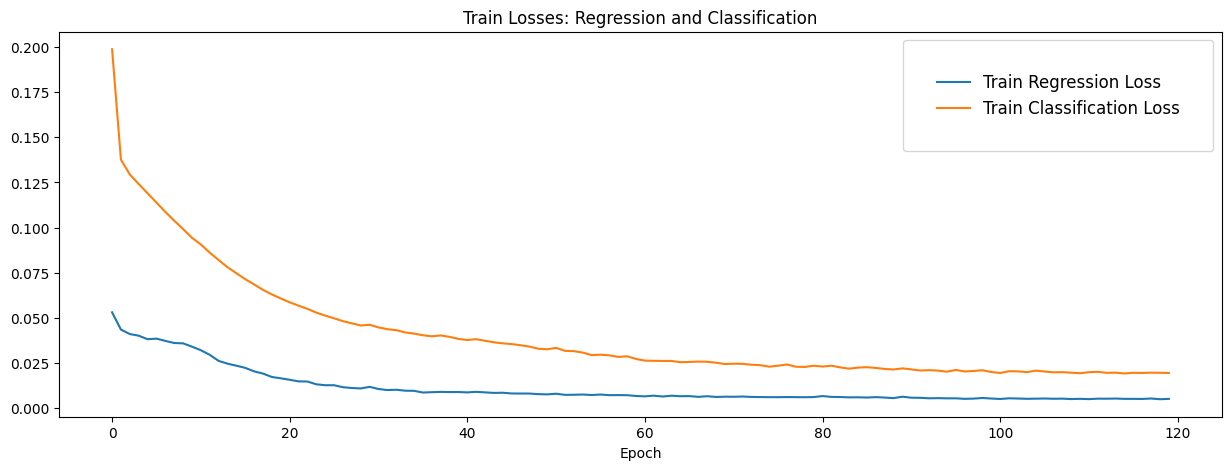

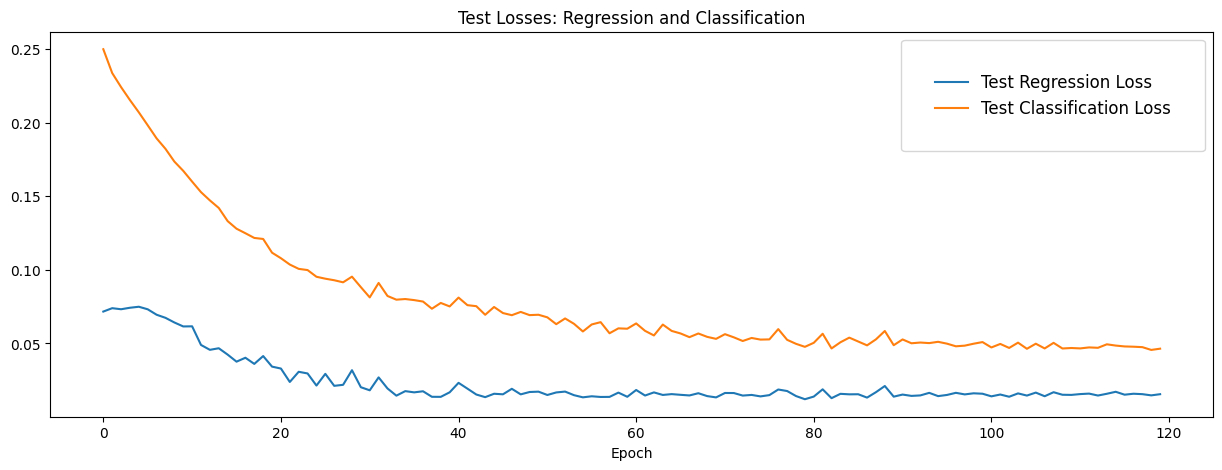

Лосс на трейне (классификация): 0.019581527726070302
Лосс на трейне (регрессия): 0.005258101567223265
Лосс на тесте (классификация): 0.04647487490924437
Лосс на тесте (регрессия): 0.015538351749306295


In [ ]:
# Определяем максимальное количество эпох, задаем оптимайзер и скедулер
max_epochs = 120
optimizer = torch.optim.AdamW(model_ssd.parameters(),lr = 0.0001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
# В эти списки будем сохранять значения лоссов (их в данном случае 2 для трейна и теста)
# Лосс классификации и лосс регрессии.
loss_regression_train = []
loss_classification_train =[]
loss_regression_valid = []
loss_classification_valid =[]
for epoch in range(max_epochs):
  # Тренируем модель, минимизируя сумму лосса классификации и регресии.
  model_ssd.train()
  train_loss_regression_epoch = 0
  train_loss_classification_epoch = 0
  valid_loss_regression_epoch = 0
  valid_loss_classification_epoch = 0
  for batch in trainloader:
    optimizer.zero_grad()
    losses = model_ssd(batch[0],batch[1])
    loss_regression = losses["bbox_regression"]
    loss_classification = losses["classification"]
    train_loss_regression_epoch += loss_regression.item()
    train_loss_classification_epoch += loss_classification.item()
    loss = loss_regression+loss_classification
    loss.backward()
    optimizer.step()
  scheduler.step()


  loss_regression_train.append(train_loss_regression_epoch/len(train_df))
  loss_classification_train.append(train_loss_classification_epoch/len(train_df))

  # Находим лоссы на тесте
  for batch in testloader:
    with torch.no_grad():
      losses = model_ssd(batch[0],batch[1])
      loss_regression = losses["bbox_regression"]
      loss_classification = losses["classification"]
      valid_loss_regression_epoch += loss_regression.item()
      valid_loss_classification_epoch += loss_classification.item()

  loss_regression_valid.append(valid_loss_regression_epoch/len(test_df))
  loss_classification_valid.append(valid_loss_classification_epoch/len(test_df))

  # Сохраняем модель каждые 10 эпох
  if epoch%10==0:
    torch.save(model_ssd.state_dict(), f"ssd-{epoch}")

  # Рисуем графики лоссов и выводим значения последних лоссов
  clear_output(wait=True)
  plt.figure(figsize=(15, 5))
  plt.plot(loss_regression_train,label = 'Train Regression Loss')
  plt.plot(loss_classification_train, label = "Train Classification Loss")
  plt.title('Train Losses: Regression and Classification')
  plt.xlabel('Epoch')
  plt.legend(prop={'size': 12},borderpad=2)
  plt.show();

  plt.figure(figsize=(15, 5))
  plt.plot(loss_regression_valid,label = 'Test Regression Loss')
  plt.plot(loss_classification_valid, label = "Test Classification Loss")
  plt.title('Test Losses: Regression and Classification')
  plt.xlabel('Epoch')
  plt.legend(prop={'size': 12},borderpad=2)
  plt.show();


  print("Лосс на трейне (классификация):",loss_classification_train[-1])
  print("Лосс на трейне (регрессия):",loss_regression_train[-1])
  print("Лосс на тесте (классификация):",loss_classification_valid[-1])
  print("Лосс на тесте (регрессия):",loss_regression_valid[-1])

Лоссы выглядят нормально, монотонно убывают на трейне и тесте и движутся примерно параллельно.

In [ ]:
torch.save(model_ssd.state_dict(), 'ssd')

In [23]:
model_ssd = ssd300_vgg16()
for i in range(13):
  for param in model_ssd.backbone.features[i].parameters():
      param.requires_grad = False
model_ssd.head = SSDHead(in_channels=[512,1024,512,256,256,256], num_anchors=[4,6,6,6,4,4], num_classes=7)
model_ssd.load_state_dict(torch.load('ssd',map_location=device))
model_ssd = model_ssd.to(device)

Посмотрим какие результаты зрительно выдает модель на тестовом датасете для 6 рандомных картинок. Видим, что в целом получается очень неплохо и боксы определяются и значения классов для этих боксов.

In [24]:
# Функция для non-max-suppression
def non_max_suppression(*args):
  data = sorted(list(zip(*args)),key = lambda x: -x[1])
  new_boxes = []
  while data:
    first_box = data[0]
    data = [el for el in data if el[2]!=data[0][2] or box_iou(el[0].unsqueeze(0),data[0][0].unsqueeze(0))<0.5]
    new_boxes.append(first_box)

  return zip(*new_boxes)

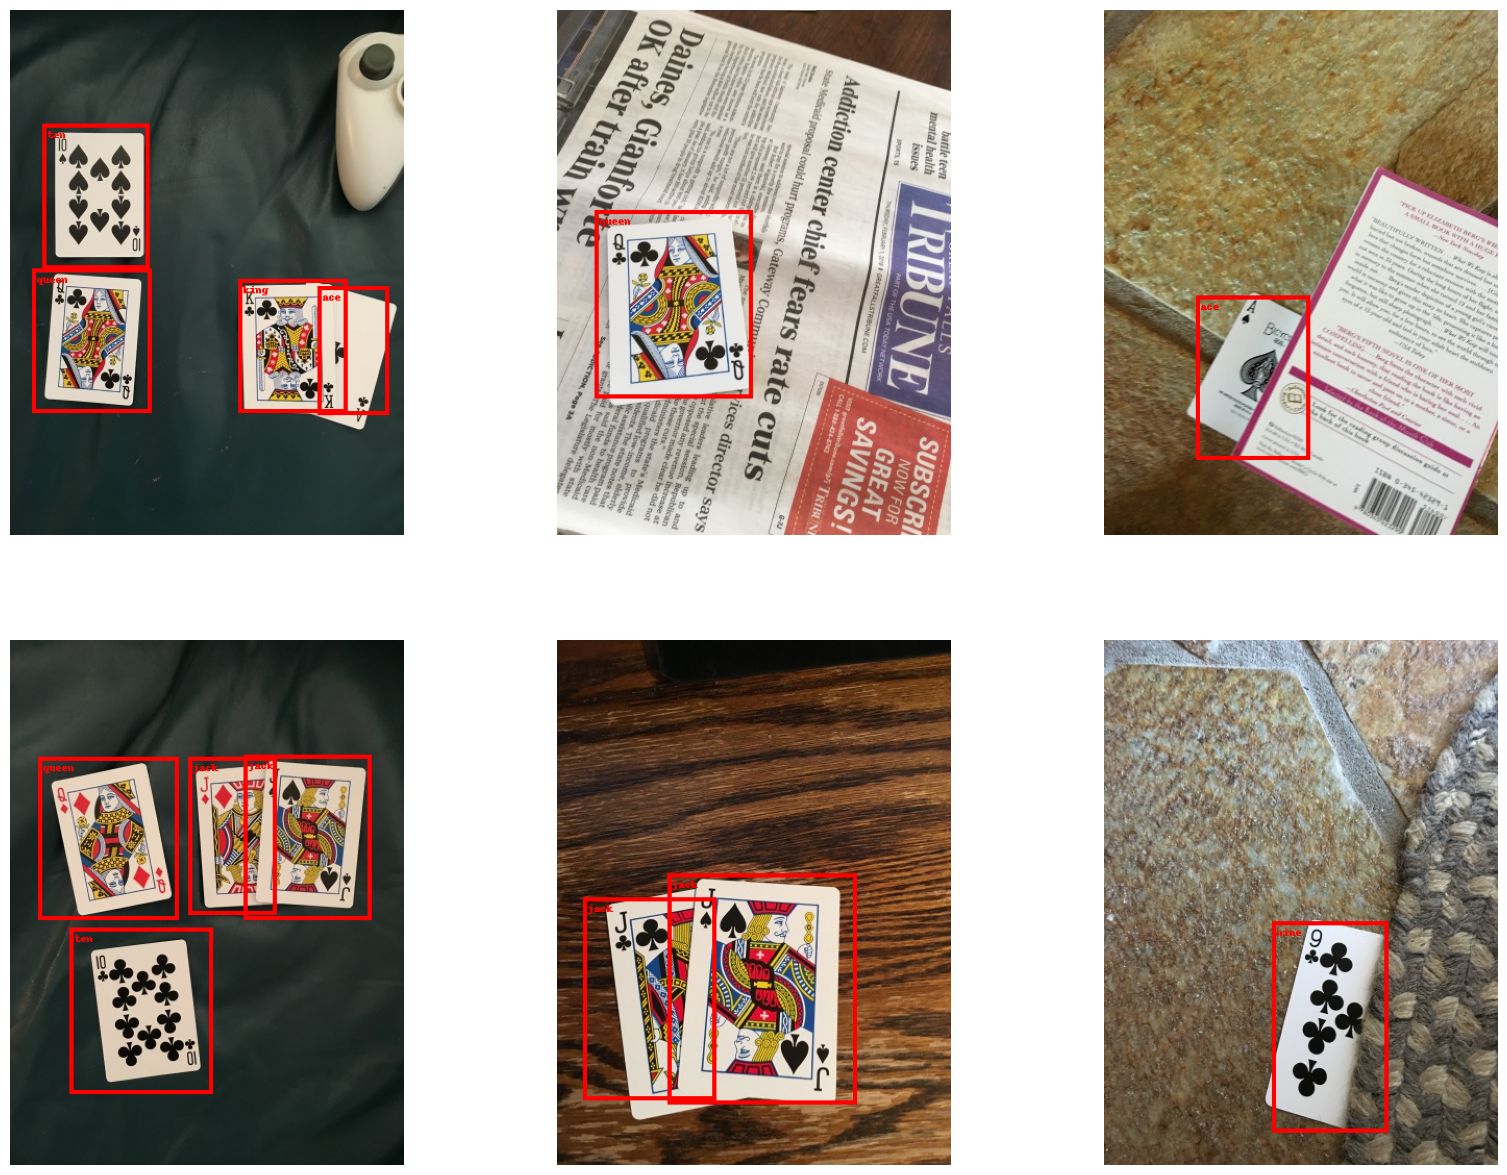

In [25]:
model_ssd.eval()
images = []
indices = np.random.choice(range(len(test_df)),size=6)
for i in range(6):
  # Делаем предсказания и фильтруем их по скору.
  prediction_ssd = model_ssd(test_df[indices[i]][0].unsqueeze(0))
  filtered = [j for j in range(len(prediction_ssd[0]['scores'])) if prediction_ssd[0]['scores'][j]>0.5]
  prediction_ssd_filtered = {}
  prediction_ssd_filtered["boxes"] = prediction_ssd[0]['boxes'][filtered]
  prediction_ssd_filtered["scores"] = prediction_ssd[0]['scores'][filtered]
  prediction_ssd_filtered["labels"] = prediction_ssd[0]['labels'][filtered]

  # Убираем одинаковые предсказания с помощью non-max-suppression
  try:
    prediction_ssd_filtered["boxes"],prediction_ssd_filtered["scores"],prediction_ssd_filtered["labels"] = \
  non_max_suppression(prediction_ssd[0]['boxes'][filtered],prediction_ssd[0]['scores'][filtered],prediction_ssd[0]['labels'][filtered])
    prediction_ssd_filtered["boxes"] = torch.stack(prediction_ssd_filtered["boxes"])
  except:
    prediction_ssd_filtered["boxes"],prediction_ssd_filtered["scores"],prediction_ssd_filtered["labels"] = torch.tensor([]),[],[]

  labels_ssd = [index_to_label[i.item()] for i in prediction_ssd_filtered["labels"]]

  box = draw_bounding_boxes(torch.tensor(255*test_df[indices[i]][0],dtype=torch.uint8), boxes=prediction_ssd_filtered["boxes"],
                                labels=labels_ssd,
                                colors="red",
                                width=4, font_size=30)
  im = to_pil_image(box.detach())

  images.append(im)

plt.figure(figsize=(20, 15))
for k in range(1,4):
  plt.subplot(2,3,k)
  plt.imshow(np.asarray(images[k-1]))
  plt.axis('off')

  plt.subplot(2,3,k+3)
  plt.imshow(np.asarray(images[k-1+3]))
  plt.axis('off')

## Faster-RCNN

Теперь обучим Faster-RCNN модель. Здесь я меняю только количество выходных классов.

In [26]:
weights_frcnn = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model_frcnn = fasterrcnn_resnet50_fpn_v2(weights=weights_frcnn, box_score_thresh=0.5).to(device)
model_frcnn.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=7, bias=True)
model_frcnn = model_frcnn.to(device)

In [27]:
# Создадим по-новой даталоадеры, так тут призодится использовать маленький бэтч сайз, иначе Cuda out of memory.
trainloader = DataLoader(train_df,batch_size=4,collate_fn=collate_fn,shuffle=True)
testloader = DataLoader(test_df,batch_size=1,collate_fn=collate_fn)

Обучение почти такое же как и SSD только здесь модель выдает 4 лосса, а не 2. Поэтому я не добавляю комментариев в код ниже.

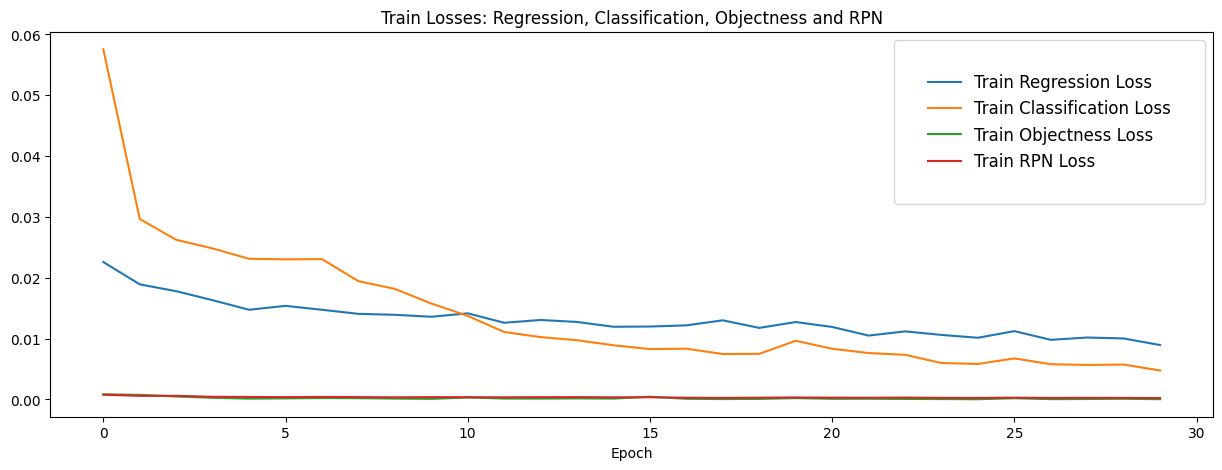

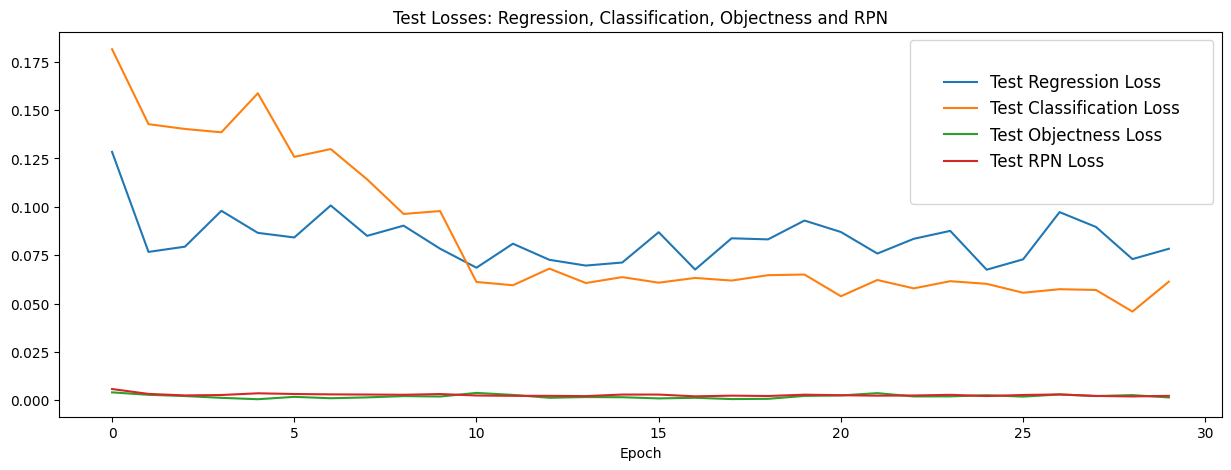

Лосс на трейне (классификация): 0.0047600027976079365
Лосс на трейне (регрессия): 0.008945828435841846
Лосс на трейне (objectness): 4.846090072950992e-05
Лосс на трейне (RPN): 0.00023235201066150644
Лосс на тесте (классификация): 0.061369875685742765
Лосс на тесте (регрессия): 0.07834384215078247
Лосс на тесте (objectness): 0.0015152703062180516
Лосс на тесте (RPN): 0.002335994067481752


In [ ]:
max_epochs = 30
optimizer = torch.optim.Adam(model_frcnn.parameters(),lr = 0.0001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
loss_regression_train = []
loss_classification_train =[]
loss_objectness_train = []
loss_rpn_train =[]
loss_regression_valid = []
loss_classification_valid =[]
loss_objectness_valid = []
loss_rpn_valid =[]
for epoch in range(max_epochs):
  model_frcnn.train()
  train_loss_regression_epoch = 0
  train_loss_classification_epoch = 0
  train_loss_objectness_epoch = 0
  train_loss_rpn_epoch = 0
  valid_loss_regression_epoch = 0
  valid_loss_classification_epoch = 0
  valid_loss_objectness_epoch = 0
  valid_loss_rpn_epoch = 0
  for batch in trainloader:
    optimizer.zero_grad()
    losses = model_frcnn(batch[0],batch[1])
    loss_regression = losses["loss_box_reg"]
    loss_classification = losses["loss_classifier"]
    loss_objectness = losses["loss_objectness"]
    loss_rpn = losses["loss_rpn_box_reg"]
    train_loss_regression_epoch += loss_regression.item()
    train_loss_classification_epoch += loss_classification.item()
    train_loss_objectness_epoch += loss_objectness.item()
    train_loss_rpn_epoch += loss_rpn.item()
    loss = loss_regression+loss_classification+loss_objectness+loss_rpn
    loss.backward()
    optimizer.step()
  scheduler.step()

  loss_regression_train.append(train_loss_regression_epoch/len(train_df))
  loss_classification_train.append(train_loss_classification_epoch/len(train_df))
  loss_objectness_train.append(train_loss_objectness_epoch/len(train_df))
  loss_rpn_train.append(train_loss_rpn_epoch/len(train_df))

  for batch in testloader:
    with torch.no_grad():
      losses = model_frcnn(batch[0],batch[1])
      loss_regression = losses["loss_box_reg"]
      loss_classification = losses["loss_classifier"]
      loss_objectness = losses["loss_objectness"]
      loss_rpn = losses["loss_rpn_box_reg"]
      valid_loss_regression_epoch += loss_regression.item()
      valid_loss_classification_epoch += loss_classification.item()
      valid_loss_objectness_epoch += loss_objectness.item()
      valid_loss_rpn_epoch += loss_rpn.item()
      loss = loss_regression+loss_classification+loss_objectness+loss_rpn

  loss_regression_valid.append(valid_loss_regression_epoch/len(test_df))
  loss_classification_valid.append(valid_loss_classification_epoch/len(test_df))
  loss_objectness_valid.append(valid_loss_objectness_epoch/len(test_df))
  loss_rpn_valid.append(valid_loss_rpn_epoch/len(test_df))

  if epoch%10==0:
    torch.save(model_frcnn.state_dict(), f"frcnn-{epoch}")

  clear_output(wait=True)
  plt.figure(figsize=(15, 5))
  plt.plot(loss_regression_train,label = 'Train Regression Loss')
  plt.plot(loss_classification_train, label = "Train Classification Loss")
  plt.plot(loss_objectness_train,label = 'Train Objectness Loss')
  plt.plot(loss_rpn_train, label = "Train RPN Loss")
  plt.title('Train Losses: Regression, Classification, Objectness and RPN')
  plt.xlabel('Epoch')
  plt.legend(prop={'size': 12},borderpad=2)
  plt.show();

  plt.figure(figsize=(15, 5))
  plt.plot(loss_regression_valid,label = 'Test Regression Loss')
  plt.plot(loss_classification_valid, label = "Test Classification Loss")
  plt.plot(loss_objectness_valid,label = 'Test Objectness Loss')
  plt.plot(loss_rpn_valid, label = "Test RPN Loss")
  plt.title('Test Losses: Regression, Classification, Objectness and RPN')
  plt.xlabel('Epoch')
  plt.legend(prop={'size': 12},borderpad=2)
  plt.show();

  print("Лосс на трейне (классификация):",loss_classification_train[-1])
  print("Лосс на трейне (регрессия):",loss_regression_train[-1])
  print("Лосс на трейне (objectness):",loss_objectness_train[-1])
  print("Лосс на трейне (RPN):",loss_rpn_train[-1])

  print("Лосс на тесте (классификация):",loss_classification_valid[-1])
  print("Лосс на тесте (регрессия):",loss_regression_valid[-1])
  print("Лосс на тесте (objectness):",loss_objectness_valid[-1])
  print("Лосс на тесте (RPN):",loss_rpn_valid[-1])

Лоссы тоже выглядят нормально, монотонно убывают (особенно лосс классификации) на трейне и тесте и движутся примерно параллельно.

In [ ]:
torch.save(model_frcnn.state_dict(), 'faster-rcnn')

In [28]:
model_frcnn = fasterrcnn_resnet50_fpn_v2(box_score_thresh=0.5).to(device)
model_frcnn.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=7, bias=True)
model_frcnn = model_frcnn.to(device)
model_frcnn.load_state_dict(torch.load('faster-rcnn',map_location=device))

<All keys matched successfully>

Также посмотрим на результаты инференса модели на рандомных картинках из теста и увидим, что в целом выходит что-то более-менее адекватное хоть и ощутимо хуже чем у SSD. Модель вообще генерит очень много лишних боксов, многие из которых нормально не отсеиваются.

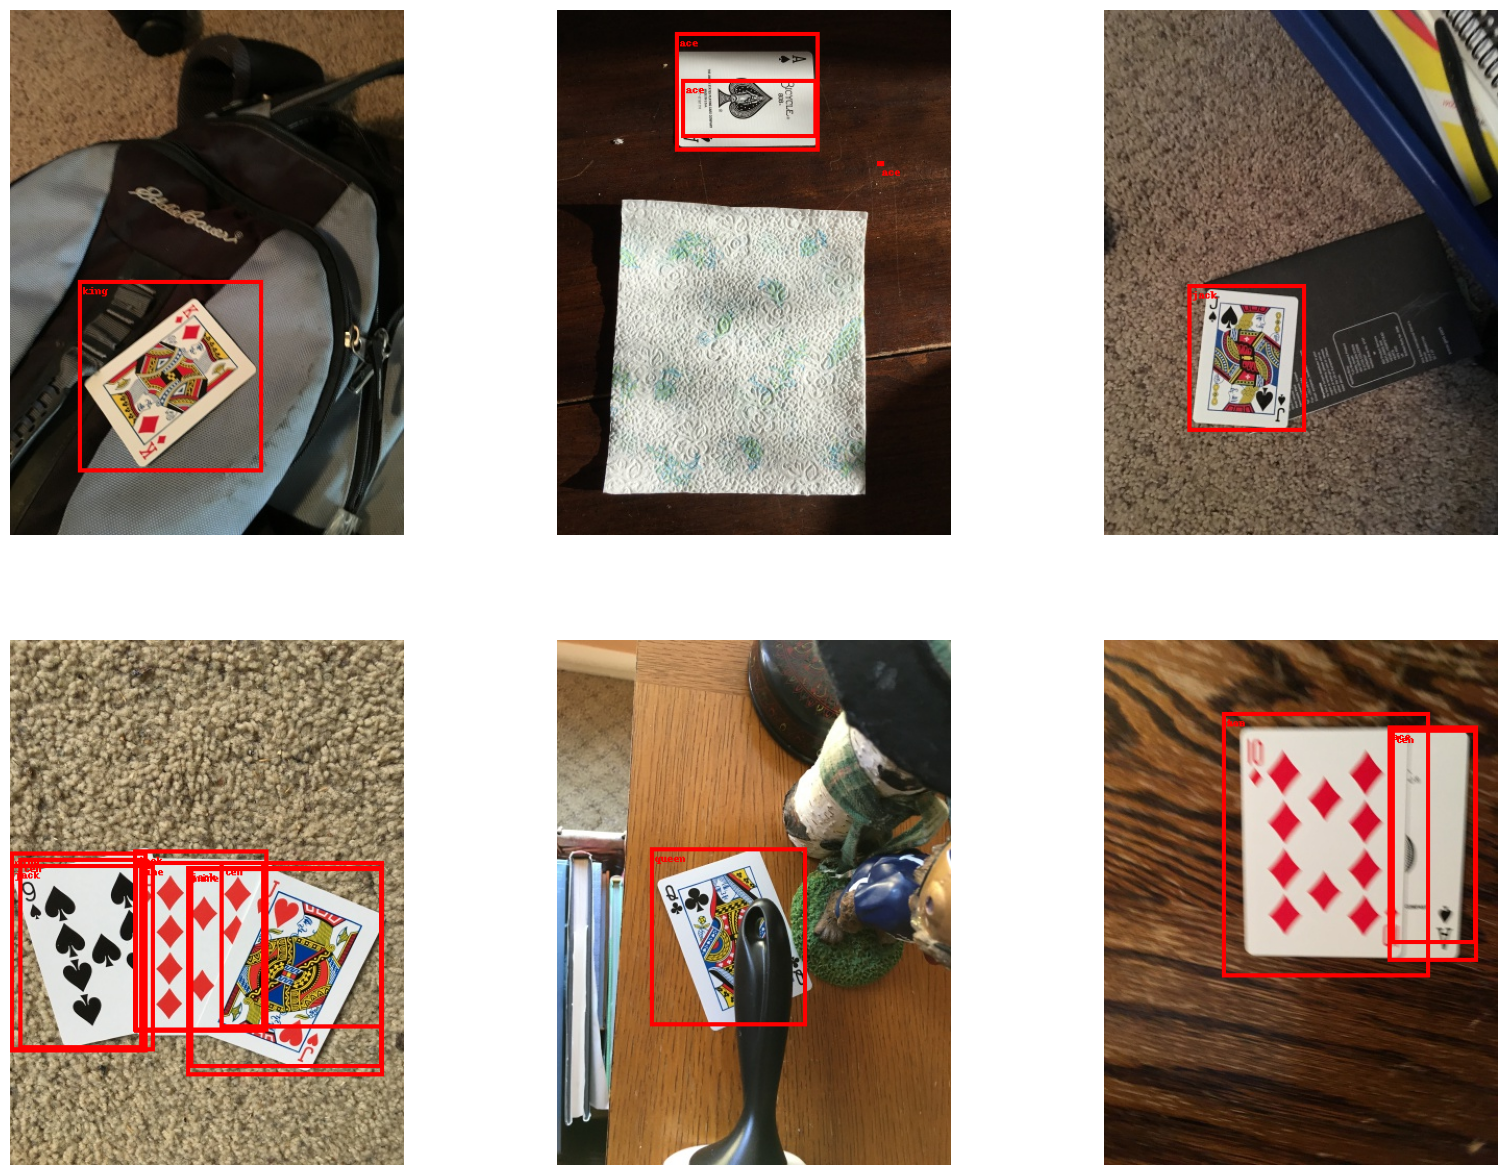

In [38]:
model_frcnn.eval()
images = []
indices = np.random.choice(range(len(test_df)),size=6)
for i in range(6):
  prediction_frcnn = model_frcnn(test_df[indices[i]][0].unsqueeze(0))
  filtered = [j for j in range(len(prediction_frcnn[0]['scores'])) if prediction_frcnn[0]['scores'][j]>0.85]
  prediction_frcnn_filtered = {}
  prediction_frcnn_filtered["boxes"] = prediction_frcnn[0]['boxes'][filtered]
  prediction_frcnn_filtered["scores"] = prediction_frcnn[0]['scores'][filtered]
  prediction_frcnn_filtered["labels"] = prediction_frcnn[0]['labels'][filtered]

  try:
    prediction_frcnn_filtered["boxes"],prediction_frcnn_filtered["scores"],prediction_frcnn_filtered["labels"] = \
  non_max_suppression(prediction_frcnn[0]['boxes'][filtered],prediction_frcnn[0]['scores'][filtered],prediction_frcnn[0]['labels'][filtered])
    prediction_frcnn_filtered["boxes"] = torch.stack(prediction_frcnn_filtered["boxes"])
  except:
    prediction_frcnn_filtered["boxes"],prediction_frcnn_filtered["scores"],prediction_frcnn_filtered["labels"] = torch.tensor([]),[],[]


  labels_ssd = [index_to_label[i.item()] for i in prediction_frcnn_filtered["labels"]]

  box = draw_bounding_boxes(torch.tensor(255*test_df[indices[i]][0],dtype=torch.uint8), boxes=prediction_frcnn_filtered["boxes"],
                                labels=labels_ssd,
                                colors="red",
                                width=4, font_size=30)
  im = to_pil_image(box.detach())

  images.append(im)

plt.figure(figsize=(20, 15))
for k in range(1,4):
  plt.subplot(2,3,k)
  plt.imshow(np.asarray(images[k-1]))
  plt.axis('off')

  plt.subplot(2,3,k+3)
  plt.imshow(np.asarray(images[k-1+3]))
  plt.axis('off')

# Реализация Метрик

В этой части я вручную реализую метрики Mean Average Precision (mAP) и кривые Precision-Recall для каждого класса.

Здесь я просто нахожу количество ground truth labels для каждого класса, чтобы потом удобно было считать recall.

In [39]:
ground_truths = {"nine":0,"ten":0,"jack":0,"queen":0,"king":0,"ace":0}
for i in range(len(test_df)):
  for j in range(len(test_df[i][1]["labels"])):
    ground_truths[index_to_label[test_df[i][1]["labels"][j].item()]]+=1

Следующая функция берет на вход модель и тестовые данные и на выходе возвращает для каждого класса боксы отсортированные по скорам с указанием того является ли каждый конкретный бокс true positive или false positive.

In [40]:
def tps_and_fps(model,data):
  model.eval()
  # В эти списки будем добавлять скор, лэйбл и индикатор того, является ли бокс true positive или нет, для каждого из боксов.
  filtered_tp = []
  filtered_labels = []
  filtered_scores = []
  # Пробегаемся циклом по всем картинкам из теста.
  for k in range(len(data)):
    filtered_tp_single = []
    filtered_labels_single = []
    filtered_scores_single = []
    # used показывает был ли уже заметчен ground truth box. Так как мы не хотим, чтобы на один ground
    # truth box приходилось больше одного true positive
    used = [0]*data[k][1]["boxes"].shape[0]
    # Находим предсказания и сортируем их по убыванию скоров.
    preds = model(data[k][0].unsqueeze(0))[0]
    boxes,scores, labels = zip(*sorted(list(zip(preds["boxes"],preds["scores"],preds["labels"])),key = lambda x: -x[1]))
    # Сделаем non-max-suppression чтобы убрать одинаковые предсказания
    boxes,scores, labels = non_max_suppression(boxes,scores,labels)
    boxes = torch.stack(boxes)
    scores = torch.stack(scores)
    labels = torch.stack(labels)
    # Считаем IoU между всеми предсказаниями и ground truths
    ious = box_iou(boxes,data[k][1]["boxes"])
    # Далее добавляем скоры, лэйблы и индикаторы tp в списки. True positive мы считаем, если пересечение с ground truth
    # по IoU больше 0.5 и ground truth box еще не был ранее заметчен с другим предсказанным боксом.
    for i in range(len(ious)):
      tp = 0
      for j in range(len(ious[i])):
        if ious[i][j]>=0.5:
          if preds["labels"][i]==data[k][1]["labels"][j] and used[j]==0:
            tp = 1
            used[j]=1
      filtered_tp_single.append(tp)
      filtered_labels_single.append(preds["labels"][i])
      filtered_scores_single.append(preds["scores"][i])

    # Добавляем значения для одной картинки в общие списки боксов.
    filtered_tp += filtered_tp_single
    filtered_labels += filtered_labels_single
    filtered_scores += filtered_scores_single

  # Созданные выше списки разюиваем на классы, сортируем и возвращаем.
  nines,tens,jacks,queens,kings,aces = [], [], [], [], [], []
  for i in range(len(filtered_tp)):
    if filtered_labels[i]==1:
      nines.append((filtered_scores[i].item(),filtered_tp[i]))
    if filtered_labels[i]==2:
      tens.append((filtered_scores[i].item(),filtered_tp[i]))
    if filtered_labels[i]==3:
      jacks.append((filtered_scores[i].item(),filtered_tp[i]))
    if filtered_labels[i]==4:
      queens.append((filtered_scores[i].item(),filtered_tp[i]))
    if filtered_labels[i]==5:
      kings.append((filtered_scores[i].item(),filtered_tp[i]))
    if filtered_labels[i]==6:
      aces.append((filtered_scores[i].item(),filtered_tp[i]))

  nines.sort(reverse=True)
  tens.sort(reverse=True)
  jacks.sort(reverse=True)
  queens.sort(reverse=True)
  kings.sort(reverse=True)
  aces.sort(reverse=True)

  return nines,tens,jacks,queens,kings,aces

Теперь создадим функцию, которая посчитает значения precision, recall и precision_smoothed (сглаженный precision, который используется для подсчета mAP по 11ти точкам). Функция также рисует графики precision-recall curve.

In [41]:
def precisons_and_recalls(nines,tens,jacks,queens,kings,aces):
  recalls = []
  precisions = []
  precisions_smoothed = []
  names = ["Nines","Tens","Jacks","Queens","Kings","Aces"]
  # Считаем precision и recall значения по мере убывания score threshold
  for j,card in enumerate([(nines,"nine"),(tens,"ten"),(jacks,"jack"),(queens,"queen"),(kings,"king"),(aces,"ace")]):
    tps = 0
    fps = 0
    recall =[0]
    precision = [1]
    precision_smoothed = []
    for i in range(len(card[0])):
      if card[0][i][1]==1:
        tps+=1
      else:
        fps+=1
      recall.append(tps/(ground_truths[card[1]]))
      precision.append(tps/(tps+fps))

    # В какой-то момент recall станет равным единице и нам уже не интересно, что находится правее по этому обрезаем хвост.
    for i in range(len(recall)):
      if recall[i]==1:
        recall = recall[:i+1]
        precision = precision[:i+1]
        break
    # Добавил единицу в конец, чтобы не было проблем с границами при интреполяции потом на всякий случай.
    recall.append(1)
    precision.append(precision[-1])

    recalls.append(recall)
    precisions.append(precision)
    # Посчитаем сглаженную версию precision-recall curve
    for i in range(len(precision)):
      precision_smoothed.append(max(precision[i:]))
    precisions_smoothed.append(precision_smoothed)


  # Нарисуем кривые Precision-Recall
  plt.figure(figsize=(15, 10))
  for j in range(3):
    plt.subplot(2,3,j+1)
    plt.plot(recalls[j],precisions[j])
    plt.plot(recalls[j],precisions_smoothed[j])
    plt.title(f"Precision-Recall Curve: {names[j]}")

    plt.subplot(2,3,j+4)
    plt.plot(recalls[j+3],precisions[j+3])
    plt.plot(recalls[j+3],precisions_smoothed[j+3])
    plt.title(f"Precision-Recall Curve: {names[j+3]}")

  plt.show()

  return recalls, precisions, precisions_smoothed

Ну и наконец, имея значения precisions и recalls, подсчитаем mAP методом 11ти точек.

In [42]:
def mAP(recalls,precisions_smoothed):
  map = 0
  names = ["Nines","Tens","Jacks","Queens","Kings","Aces"]
  for i in range(6):
    summa = 0
    # Интерполируем значения recalls и precisions_smoothed, используя функцию interp1d из scipy.
    prc = interp1d(recalls[i], precisions_smoothed[i], kind="previous")
    for j in np.arange(0,1.1,0.1):
      summa += prc(j)
    summa = (1/11)*summa
    map += summa
    print(f"Average Precision (AP) for {names[i]} is", summa)
  print("Mean Average Precision (mAP) for SSD model is", map/6)

Применим функции выше сначала к модели SSD и посмотрим какую точность она выдает согласно метрике mAP.

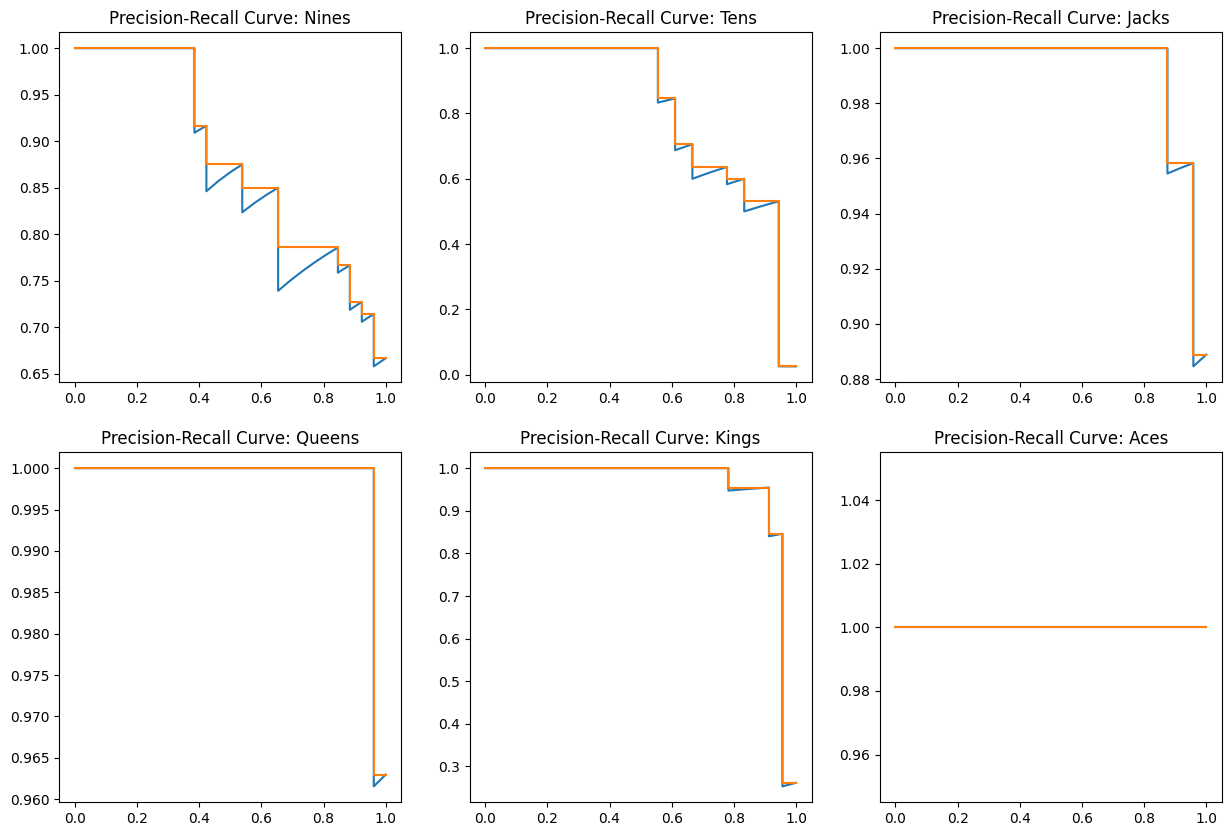

Average Precision (AP) for Nines is 0.8733667847304211
Average Precision (AP) for Tens is 0.7853764197132583
Average Precision (AP) for Jacks is 0.9861111111111113
Average Precision (AP) for Queens is 0.9966329966329968
Average Precision (AP) for Kings is 0.9245867768595043
Average Precision (AP) for Aces is 1.0
Mean Average Precision (mAP) for SSD model is 0.9276790148412153


In [43]:
nines,tens,jacks,queens,kings,aces = tps_and_fps(model_ssd,test_df)
recalls, precisions, precisions_smoothed = precisons_and_recalls(nines,tens,jacks,queens,kings,aces)
mAP(recalls,precisions_smoothed)

Значение mAP 0.92 это очень хороший результат. Кривые AP для всех классов тоже выглядят очень хорошо, для тузов например площадь равна ровно 1 (максимум возможного). Десятки и девятки определяются хуже других классов, но даже там результат очень хорош.

К сожалению, для Faster-RCNN подсчитать метрики не удалось из-за того, что она потребляет сумасшедшее количество оперативы и выдает ошибку CUDA out of memory :(

# Применение детекции карт на практике

Зачем может в принципе понадобиться детектировать игральные карты.

1. Можно использовать детекцию карт при играх в покер.

При трансляциях игр в покер, хоть игроки и не знают карт друг друга, зрителям интереснее смотреть матчи, зная все карты. Для этого игроки прислоняют карты лицом вниз к камере, встроенной в стол, чтобы показать свои карты. Потом значения карт всех игроков показываются на экране сбоку в удобном схематичном виде.

Я не уверен делается ли это сейчас вручную человеком или уже было автоматизировано, но в целом здесь можно вполне использовать модель детекции для быстроты и удобства.

Также такой подход может использоваться и вне трансляций, а просто для ведения исторической статистики по матчам, чтобы всегда знать у какого игрока в какой момент какие были карты на руках.

2. Можно создать робота, который будет играть с людьми в реальные карты.

Для развлечения или тренировки можно создать робота, который будет играть с людьми в реальные карты (не виртуальные). Например, есть роботы, которые играют в шахматы с помощью специальной руки для хватания фигур.

Робот будет иметь камеру для съемки текущей позиции, с помощью модели детекции определять карты на столе (и соответственно сохранять в память выбывшие карты) и решать какие действия принимать.

3. Можно использовать для помощи слабовидящим людям.

Чтобы помощь слабовидящим людям играть в карты можно, например, использовать камеру и наушник. Камера будет снимать карты в руке игрока и на столе, модель будет детектировать их и сообщать игроку в наушник какие карты у него на руках и какие на столе. Например, такой подход вполне может использоваться для игры в покер (для более активных игр наверное будут проблемы).